<a href="https://colab.research.google.com/github/VictorCampelo/Cluster-Labeler-Using-CAIM-Discretizer/blob/master/CAIBAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
!pip3 install caimcaim
!pip3 install kneed
!pip3 install sklearn -U

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [157]:
import warnings
warnings.filterwarnings("ignore")

In [260]:
#importing the libraries
from caimcaim import CAIMD
from itertools import compress 
from kneed import KneeLocator
from itertools import cycle, islice

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, \
estimate_bandwidth, SpectralClustering, AgglomerativeClustering, Birch
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from yellowbrick.cluster import InterclusterDistance

from numpy import unique
from numpy import where

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import homogeneity_completeness_v_measure
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from itertools import cycle

In [159]:
#importing the Iris dataset with pandas
iris = load_iris()
digt = load_digits()
wine = load_wine()
canc = load_breast_cancer()

df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_digt = pd.DataFrame(digt.data)
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_canc = pd.DataFrame(canc.data, columns=canc.feature_names)

In [160]:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [161]:
df_digt.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [162]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [163]:
df_canc.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [506]:
def preProcess(X):
  # Standardize data
  # Normalizing the Data
  scaler = StandardScaler()
  # scaler = MinMaxScaler()
  return normalize(scaler.fit_transform(X))

In [449]:
def PCARedution(X):
  # Reducing the dimensions of the data 
  pca = PCA(n_components = 3) 
  X1 = pca.fit_transform(X)
  return X1

In [166]:
def Elbow_kneeLocator(X):
  clusters = []
  best_n_clusters = 0
  best_sil = 0
  for i in range(1, 11):
      km = KMeans(n_clusters=i).fit(X)
      clusters.append(km.inertia_)
      labels = km.labels_
      if len(set(labels)) <= 1: continue
      sil = silhouette_score(X, labels)
      if sil > best_sil:
        best_sil = sil
        best_n_clusters = i
      
  fig, ax = plt.subplots()
  sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
  ax.set_title('Searching for Elbow')
  ax.set_xlabel('Clusters')
  ax.set_ylabel('Inertia')

  plt.show()

  kl = KneeLocator(range(1, 11), 
                   clusters, 
                   curve="convex", 
                   direction="decreasing")
  print("\nResult finding by Knee Locator function: ")
  print(kl.elbow)
  print("\n")
  return best_n_clusters

In [395]:
def clusteringKmeans(X, n_c):
  if n_c == 0:
    clusters = []
    best_n_clusters = 0
    best_sil = 0
    for i in range(1, 11):
        km = KMeans(n_clusters=i).fit(X)
        clusters.append(km.inertia_)
        labels = km.labels_
        if len(set(labels)) <= 1: continue
        sil = calinski_harabasz_score(X, labels)
        # sil = silhouette_score(X, labels)
        if sil > best_sil:
          best_sil = sil
          best_n_clusters = i
    n_c = best_n_clusters

  model = KMeans(n_clusters=n_c).fit(X)
  
  for cluster in unique(model.labels_):
    row_ix = where(model.labels_ == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1], s=200)

  plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
              marker='*', s=300,
              c='r', label='centroid')
  plt.show()
  return model.labels_, n_c

In [345]:
def clusteringAffinityPropagation(X):
  pref = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]
  best_pref = 0
  best_sil = 0
  for i in pref:
    model = AffinityPropagation(preference=i, max_iter=500).fit(X)
    cluster_centers_indices = model.cluster_centers_indices_
    labels = model.labels_

    if len(set(labels)) <= 1 or len(set(labels)) > len(X)-1: continue
    sil = calinski_harabasz_score(X, labels)
    # sil = silhouette_score(X, labels, metric='sqeuclidean')
    if sil > best_sil:
      best_sil = sil
      best_pref = i

  model = AffinityPropagation(preference=best_pref, max_iter=500).fit(X)
  cluster_centers_indices = model.cluster_centers_indices_
  labels = model.labels_

  n_clusters_ = len(cluster_centers_indices)

  print('Estimated number of clusters: %d' % n_clusters_)
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      cluster_center = X[cluster_centers_indices[k]]
      plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
      plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
              markeredgecolor='k', markersize=14)
      for x in X[class_members]:
          plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [326]:
def clusteringAgglomerativeClustering (X, n_c):
  best_n_cluster = 0
  best_sil = 0
  if n_c == 0:
    for i in range(1, 11):
      model = AgglomerativeClustering(n_clusters=i).fit(X)
      labels = model.labels_

      if len(set(labels)) <= 1: continue
      sil = calinski_harabasz_score(X, labels)
      # sil = silhouette_score(X, labels, metric='sqeuclidean')
      if sil > best_sil:
        best_sil = sil
        best_n_cluster = i

    model = AgglomerativeClustering(n_clusters=best_n_cluster).fit(X)
    labels = model.labels_

    n_clusters_ = model.n_clusters_

    print('Estimated number of clusters: %d' % n_clusters_)
  else:
    model = AgglomerativeClustering(n_clusters=n_c).fit(X)
    labels = model.labels_

    n_clusters_ = model.n_clusters_
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      plt.scatter(X[class_members, 0], X[class_members, 1], s=200, c=col)
      # plt.plot(X[class_members, 0], X[class_members, 1], col + '.')

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [327]:
def clusteringMeanShift(X):
  best_band = 0
  best_sil = 0
  quant = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
  for i in quant:
    bandwidth = estimate_bandwidth(X, quantile=i) # Manually set the quantile to get num clusters = 3

    model = MeanShift(bandwidth=bandwidth).fit(X)
    labels = model.labels_
    cluster_centers = model.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    if len(set(labels)) <= 1: continue
    sil = calinski_harabasz_score(X, labels)
    # sil = silhouette_score(X, labels, metric='sqeuclidean')
    if sil > best_sil:
      best_sil = sil
      best_band = bandwidth

  model = MeanShift(bandwidth=best_band, bin_seeding=True).fit(X)
  labels = model.labels_
  cluster_centers = model.cluster_centers_

  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)

  print('Estimated number of clusters: %d' % n_clusters_)
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      plt.scatter(X[class_members, 0], X[class_members, 1], s=200, c=col)
      # plt.plot(X[class_members, 0], X[class_members, 1], col + '.')

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [328]:
def clusteringSpectralClustering(X, n_c):
  best_n_clusters = 0
  best_sil = 0
  if n_c == 0:
    for i in range(1,11):
      model = SpectralClustering(n_clusters=i, random_state=0).fit(X)
      labels = model.labels_

      labels_unique = np.unique(labels)
      n_clusters_ = len(labels_unique)

      if len(set(labels)) <= 1: continue
      sil = calinski_harabasz_score(X, labels)
      # sil = silhouette_score(X, labels, metric='sqeuclidean')
      if sil > best_sil:
        best_sil = sil
        best_n_clusters = i

    model = SpectralClustering(n_clusters=best_n_clusters, random_state=0).fit(X)
    labels = model.labels_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    print('Estimated number of clusters: %d' % n_clusters_)
  else:
    model = SpectralClustering(n_clusters=n_c, random_state=0).fit(X)
    labels = model.labels_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      plt.scatter(X[class_members, 0], X[class_members, 1], s=200, c=col)
      # plt.plot(X[class_members, 0], X[class_members, 1], col + '.')

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [329]:
def clusteringBirch(X, n_c):
  best_n_clusters = 0
  best_sil = 0
  if n_c == 0:
    for i in range(1,11):
      model = Birch(n_clusters = i).fit(X)
      labels = model.labels_

      labels_unique = np.unique(labels)
      n_clusters_ = len(labels_unique)

      if len(set(labels)) <= 1: continue
      sil = calinski_harabasz_score(X, labels)
      # sil = silhouette_score(X, labels, metric='sqeuclidean')
      if sil > best_sil:
        best_sil = sil
        best_n_clusters = i

    model = Birch(n_clusters = best_n_clusters).fit(X)
    labels = model.labels_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    print('Estimated number of clusters: %d' % n_clusters_)
  else:
    model = Birch(n_clusters = n_c).fit(X)
    labels = model.labels_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      plt.scatter(X[class_members, 0], X[class_members, 1], s=200, c=col)
      # plt.plot(X[class_members, 0], X[class_members, 1], col + '.')

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [330]:
def clusteringDBSCAN(X):
  epss = [0.001, 0.01, 0.03, 0.07, 0.1, 0.13, 0.17, 0.2, 0.23, 0.27, 0.3, 0.33, 0.37, 
          0.4, 0.43, 0.47, 0.5, 0.53, 0.57, 0.6]
  best_sil = 0
  best_eps = 0
  for eps in epss:
    model = DBSCAN(eps=eps).fit(X)
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    if len(set(labels)) <= 1: continue
    sil = calinski_harabasz_score(X, labels)
    # sil = silhouette_score(X, labels)
    if sil > best_sil:
      best_sil = sil
      best_eps = eps
  print(best_eps)
  min_samples = [1,2,3,4,5,6,7,8,9,10]
  best_min_sa = 0
  best_sil = 0
  for i in min_samples:
    model = DBSCAN(eps=best_eps, min_samples=i).fit(X)
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if len(set(labels)) <= 1: continue
    sil = calinski_harabasz_score(X, labels)
    # sil = silhouette_score(X, labels)
    if sil > best_sil:
      best_sil = sil
      best_min_sa = i
  
  model = DBSCAN(eps=best_eps, min_samples=best_min_sa).fit(X)
  core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
  core_samples_mask[model.core_sample_indices_] = True
  labels = model.labels_

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  
  unique_labels = set(labels)
  colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      if k == -1:
          # Black used for noise.
          col = [0, 0, 0, 1]

      class_member_mask = (labels == k)

      xy = X[class_member_mask & core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=14)

      xy = X[class_member_mask & ~core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)
  
  plt.show()

  return model.labels_, len(set(labels))

In [533]:
def caim(df, target):
  caim = CAIMD()
  caim.fit(df, target)

  print("\nCaim splited scheme: ")
  print(caim.split_scheme)
  print()

  return caim.split_scheme

In [510]:
def clustersAtrGenerate(labels, splited_sheme, type, n_clusters_kl):
  cluster_x_atr = {}
  for num_cluster in range(len(unique(labels))):
    cluster_x_atr[num_cluster] = []
  for i, fx in enumerate(splited_sheme):
    zone = []
    res = list(zip(splited_sheme[fx], splited_sheme[fx][1:] + splited_sheme[fx][:1]))
    res.pop()
    # # print(res)
    # # if type == 1 or type == 5 or type == 6:
    # if type == 99:
    #   for j, zones in enumerate(res):
    #     if (j+1) >= n_clusters_kl:
    #       cluster_x_atr[0].append(zones)
    #       continue  
    #     cluster_x_atr[j+1].append(zones)
    # else: 
    for j, zones in enumerate(res):
      cluster_x_atr[j].append(zones)
  print("Range of values ​​by clusters obtained by the CAIM method")
  print(cluster_x_atr)
  print("\n")
  return cluster_x_atr

In [653]:
def calc_perc(labels, df, cluster_x_atr):
  cluster = []
  for i, num_cluster in enumerate(range(len(unique(labels)))):
    number_entries = len(df[df['target'] == num_cluster])
    perc = []
    print("cluster %s" % i)
    if number_entries < 1: continue

    #columns
    for l, entry in enumerate(df):
      if entry == 'target': continue
      #lines
      count = 0
      k = 0
      for j, cl in enumerate(range(len(unique(labels)))):
        max = 0
        for row in df[df['target'] == num_cluster][entry]:
          if row >= cluster_x_atr[j][l][0] and \
          row <= cluster_x_atr[j][l][1]:
            max += 1
        
        if max > count:
          count = max
          k = j
      perc.append([round((count/number_entries)*100), cluster_x_atr[k][l], 
                  number_entries, number_entries-count])
      print(perc[l][0], perc[l][1], perc[l][2], perc[l][3])
    cluster.append(perc)
  print("Accuracy of each attribute in each cluster")
  print(cluster)
  print()
  return cluster

In [334]:
def standard_method(perc_atr_by_cluster, names):
  #standard
  print("Labels by Standard Method: ")
  list_label_standard = []
  for i, v1 in enumerate(perc_atr_by_cluster):
    print('Cluster %s' % i)
    rot = ""
    base = 0
    j = 1
    params = ["Attribute name", "Accuracy", "Interval", "Number of elements", \
              "Erro"] 
    rot_dict = dict.fromkeys(params, None)

    for porc_interval, name in zip(v1, names):
      if porc_interval[0] >= base:
        rot_dict["Attribute name"] = name
        rot_dict["Accuracy"] = porc_interval[0]
        rot_dict["Interval"] = porc_interval[1]
        rot_dict["Number of elements"] = porc_interval[2]
        rot_dict["Erro"] = porc_interval[3]
        rot = "(Attribute name: " +name + \
              " Interval: "+str(porc_interval[1]) + ")"
        if j <= len(porc_interval):
          rot += " - "
        base = porc_interval[0]
    
    print("Attribute name: " +rot_dict["Attribute name"] +", Accuracy: "+ \
          str(rot_dict["Accuracy"])+"%,"+ " Interval: "+str(rot_dict["Interval"])+ \
          ", Number of elements: " + str(rot_dict["Number of elements"]) + \
          ", Erro: " + str(rot_dict["Erro"]))
    list_label_standard.append(rot)
  print("\n")
  return list_label_standard

In [335]:
def alternative_method(perc_atr_by_cluster, names, var):
  #alternative
  print("Labels by Alternative Method: ")
  list_label_alternative = []
  for i, v1 in enumerate(perc_atr_by_cluster):
    print('Cluster %s' % i)
    base = 0
    for porc_interval, name in zip(v1, names):
      if porc_interval[0] >= base:
        base = porc_interval[0]
    rot = ""
    j = 1
    for porc_interval, name in zip(v1, names):
      if porc_interval[0] >= (base-var):
        print("Attribute name: " +name +", Accuracy: "+ str(porc_interval[0])+"%,"+\
        " Interval: "+str(porc_interval[1])+ ", Number of elements: " \
        + str(porc_interval[2]) + ", Erro: " + str(porc_interval[3]))
        
        rot = "(Attribute name: " +name + " Interval: "+str(porc_interval[1]) + ")"

        if j <= len(porc_interval):
          rot += " - "
    list_label_alternative.append(rot)
  print("\n")
  return list_label_alternative

In [336]:
def result2df(df, list_label_standard, list_label_alternative):
  stand = []
  alter = []

  for i, row in df.iterrows():
    stand.append(list_label_standard[int(row["target"])]) 
    alter.append(list_label_alternative[int(row["target"])])

  df['label_CAIBAL_standard'] = stand
  df['label_CAIBAL_alternative'] = alter

  return df

In [433]:
def correct_labels(labels, labels_set):
  corr_labels = []

  for i, lb in enumerate(labels):
    j = list(labels_set).index(lb)
    corr_labels.append(j)

  return corr_labels

In [660]:
def caibal(df, type_cluster, discretization_type, var, n_clusters, prepro, is_sklearn_df, has_target):
  # X.data, X.target, X.feature_names
  # caibal(X, cluster_alg, discretization_type, var, n_clusters, prepro, is_sklearn_df, has_target)
  
  if has_target:
    target = df.target

  if is_sklearn_df:
    names = df.feature_names
    X = df.data
    df = pd.DataFrame(X)
  else:
    X = df.values
    names = df.columns
   
  if prepro:
    df = preProcess(df)
    # X = PCARedution(X)

  if type_cluster == 1:
    # np.random.seed(0)
    # if n_clusters == 0:
    #   n_clusters = Elbow_kneeLocator(X)
    labels, n_clusters = clusteringKmeans(X, n_clusters)

    # print(target)
    # print(labels)
    # labels_set = df.target.unique()
    # print(labels_set)
    # # df['target'] = correct_labels(labels, labels_set)

    # print(df['target'].values)
    splited_sheme = caim(df.values, labels)
    df['target'] = labels
    cluster_x_atr = clustersAtrGenerate(df.target, splited_sheme, type_cluster, n_clusters)

    print(cluster_x_atr)

    if has_target == 1:
      print("Accuracy:")
      print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
      print("\n")

  elif type_cluster == 2:
    labels, n_clusters = clusteringAffinityPropagation(X)
    splited_sheme = caim(df.values, labels)
    df['target'] = labels
    cluster_x_atr = clustersAtrGenerate(df.target, splited_sheme, type_cluster, n_clusters)

    print(cluster_x_atr)

    if has_target == 1:
      print("Accuracy:")
      print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
      print("\n")

  elif type_cluster == 3:
    labels, n_clusters = clusteringDBSCAN(X)
    splited_sheme = caim(df.values, labels)
    df['target'] = labels
    cluster_x_atr = clustersAtrGenerate(df.target, splited_sheme, type_cluster, n_clusters)

    print(cluster_x_atr)

    if has_target == 1:
      print("Accuracy:")
      print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
      print("\n")
  
  elif type_cluster == 4:
    labels, n_clusters = clusteringAgglomerativeClustering(X, n_clusters)
    splited_sheme = caim(df.values, labels)
    df['target'] = labels
    cluster_x_atr = clustersAtrGenerate(df.target, splited_sheme, type_cluster, n_clusters)

    print(cluster_x_atr)

    if has_target == 1:
      print("Accuracy:")
      print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
      print("\n")
  
  elif type_cluster == 5:
    np.random.seed(0)
    labels, n_clusters = clusteringMeanShift(X)
    splited_sheme = caim(df.values, labels)
    df['target'] = labels
    cluster_x_atr = clustersAtrGenerate(df.target, splited_sheme, type_cluster, n_clusters)

    print(cluster_x_atr)

    if has_target == 1:
      print("Accuracy:")
      print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
      print("\n")
  
  elif type_cluster == 6:
    np.random.seed(0)
    labels, n_clusters = clusteringSpectralClustering(X, n_clusters)
    splited_sheme = caim(df.values, labels)
    df['target'] = labels
    cluster_x_atr = clustersAtrGenerate(df.target, splited_sheme, type_cluster, n_clusters)

    print(cluster_x_atr)

    if has_target == 1:
      print("Accuracy:")
      print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
      print("\n")

  perc_atr_by_cluster = calc_perc(labels, df, cluster_x_atr)

  if discretization_type == 1:
    result = standard_method(perc_atr_by_cluster, names)
  else: 
    result = alternative_method(perc_atr_by_cluster, names, var)
  
  # return result2df(df, list_label_standard, list_label_alternative)

Use external CSV file (1) or load sklearn datasets (2): 1
This csv file has a target column?(1 - Yes, 0 - No): 0
Enter with the path file: /content/seedsData_original.csv
This csv file has a index columns?(1 - Yes, 0 - No):0
1 - Kmeans
2 - Affinity Propagation
3 - DBSCAN
4 - Agglomerative Clustering
5 - Mean shift
6 - Spectral Clustering
Choise the clustering algorithm: 1
Desire set manually the number of clusters? (1 - Yes, 0 - No) 1
Enter with the number of clusters: 3
1 - Pattern Method
2 - Alternative Method: 1
Wish standarnize data? (1 - Yes, 0 - No) 0


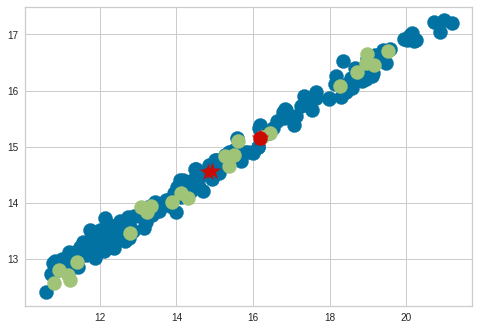

Categorical [7]
# 0  GLOBAL CAIM  54.994086239524194
# 1  GLOBAL CAIM  55.721777576428735
# 2  GLOBAL CAIM  69.33898305084746
# 3  GLOBAL CAIM  55.105500550055005
# 4  GLOBAL CAIM  54.994818652849744
# 5  GLOBAL CAIM  55.037837837837834
# 6  GLOBAL CAIM  55.059985041136876

Caim splited scheme: 
{0: [10.59, 12.79, 12.8, 21.18], 1: [12.41, 12.72, 13.83, 17.25], 2: [0.8081, 0.8831, 0.9183, 905.0], 3: [4.899, 4.981, 5.046, 6.675], 4: [2.63, 2.716, 2.717, 4.033], 5: [0.7651, 1.955, 8.456, 903.0], 6: [4.519, 4.805, 4.828, 6.55]}

Range of values ​​by clusters obtained by the CAIM method
{0: [(10.59, 12.79), (12.41, 12.72), (0.8081, 0.8831), (4.899, 4.981), (2.63, 2.716), (0.7651, 1.955), (4.519, 4.805)], 1: [(12.79, 12.8), (12.72, 13.83), (0.8831, 0.9183), (4.981, 5.046), (2.716, 2.717), (1.955, 8.456), (4.805, 4.828)], 2: [(12.8, 21.18), (13.83, 17.25), (0.9183, 905.0), (5.046, 6.675), (2.717, 4.033), (8.456, 903.0), (4.828, 6.55)]}


{0: [(10.59, 12.79), (12.41, 12.72), (0.8081, 0.8831), 

In [668]:
resp = int(input("Use external CSV file (1) or load sklearn datasets (2): "))
is_sklearn_df = False
if resp == 1:
  has_target = int(input("This csv file has a target column?(1 - Yes, 0 - No): "))
  path = input("Enter with the path file: ")
  index = int(input("This csv file has a index columns?(1 - Yes, 0 - No):"))
  if index:
    index_col = input("Enter with the name of index column: ")
    df = pd.read_csv(path, index_col=index)
  else:
    df = pd.read_csv(path)
else:
  has_target = 1
  is_sklearn_df = True
  print("1 - Iris\n2 - Wine\n3 - Breast Cancer")
  resp = int(input("Select Dataset: "))
  if resp == 1:
    df = load_iris()
  elif resp == 2:
    df = load_wine()
  else:
    df = load_breast_cancer()
  
  # print(df.DESCR)

print("1 - Kmeans\n2 - Affinity Propagation\n3 - DBSCAN\n4 - Agglomerative Clustering\n\
5 - Mean shift\n6 - Spectral Clustering")
cluster_alg = int(input("Choise the clustering algorithm: "))
n_clusters = 0
if cluster_alg == 1 or cluster_alg == 4 or cluster_alg == 6:
  auto_n_cluster = int(input("Desire set manually the number of clusters? (1 - Yes, 0 - No) "))
  if auto_n_cluster == 1:
    n_clusters = int(input("Enter with the number of clusters: "))

discretization_type = int(input("1 - Pattern Method\n2 - Alternative Method: "))
var = 0
if discretization_type == 2:
  var = int(input("Type the varience value: "))

prepro = int(input("Wish standarnize data? (1 - Yes, 0 - No) "))

# DATAFRAME, CLUSTER TYPE, VAR. MIN, NUMBER OF CLUSTER, APPLY PREPROCESSING.
caibal(df, cluster_alg, discretization_type, var, n_clusters, prepro, is_sklearn_df, has_target)

In [663]:
df = pd.read_csv('/content/seedsData_original.csv')
df

,V1,V2,V3,V4,V5,V6,V7,target
0,15.26,14.84,871.0000,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,905.0000,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
